# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [2]:
# For deep neural networks
import tensorflow as tf

# For data representation
import numpy as np
import random

# For handling files
import os

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
env = gym.make("Asterix-v0")
env.seed(1337)
# I have installed pyglet-1.5.11 for it work with BigSur

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[1337, 17452119]

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [3]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation space: Box(210, 160, 3)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

In [4]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
agent = RandomAgent(env)
numberOfEpisodes = 10
# for steps in range(numberOfEpisodes):
#     current_obs = env.reset()
#     done = False
#     while not done:
#         action = agent.get_action(current_obs)
#         next_obs, reward, done, info = env.step(action)
#         total_reward += reward
#         env.render()
print("Average reward: {}".format(total_reward/numberOfEpisodes))

Average reward: 0.0


### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


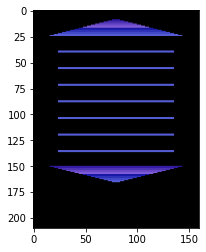

float32


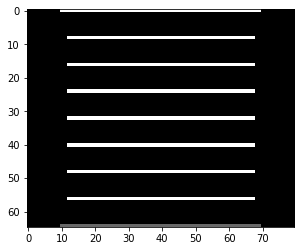

In [127]:
obs = env.reset()
from skimage.color import rgb2gray

def preprocess_observation(observation):
    img = observation[23:153:2, ::2] # This becomes 90, 80, 3
#     print(img.shape)
#     print(img.shape)
#     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
    img = rgb2gray(img)
    img = img.astype(np.float32) # normalize from -128 to 127
    return img.reshape(65, 80)

plt.imshow(obs)
plt.show()
print(preprocess_observation(obs)[0].dtype)
plt.imshow(preprocess_observation(obs).reshape(65,80), cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [128]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = (65, 80, 4)
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
FRAME_STACK_SIZE = 4
MEMORY_SIZE = 25000
MIN_REPLAY_SIZE = 20000
LEARNING_RATE = 0.0001

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [129]:
from collections import deque

class QLearningAgent():
    def __init__(self, env, lr=LEARNING_RATE):
        self.lr = lr
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()

        # Saving the session
#         self.saver = tf.compat.v1.train.Saver()
#         self.sess = tf.compat.v1.Session()
#         if os.path.isfile(self.checkpoint_path + ".index"):
#             self.saver.restore(self.sess, self.checkpoint_path)
#         else:
# #             self.sess.run(tf.global_variables_initializer())
#             self.update_target()
# #             self.sess.run(self.copy_online_to_target)

    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        # reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if step <= MIN_REPLAY_SIZE or np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            q_values = self.online.predict(np.stack(self.stack_frames(step-1).reshape(-1, *INPUT_SHAPE)))
            return np.argmax(q_values) # optimal action
    
    def train(self):
        """Train the online model and update the loss value
        """
        if len(self.memory) < BATCH_SIZE + FRAME_STACK_SIZE:
            return
        
        # https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf SAY ABOUT NUMBER OF FRAMES
        sample_indexes = random.sample(range(FRAME_STACK_SIZE - 1, len(self.memory) - 1), BATCH_SIZE)
        
        curr_states = np.stack([self.stack_frames(idx) for idx in sample_indexes])
        states_q_vals = self.online.predict(curr_states)
        
        next_states = np.stack([self.stack_frames(idx, 3) for idx in sample_indexes])
        targets_q_vals = self.target.predict(next_states)

        Y = []
        
        for idx, memory_index in enumerate(sample_indexes):
            curr_state, action, reward, next_state, done = self.memory[memory_index]
            if done:
                future_q_val = reward
            else:
                future_q_val = reward + np.amax(targets_q_vals[idx]) * self.discount_rate
            
            # Get the current Q value
            curr_q_val = states_q_vals[idx]
            curr_q_val[action] = future_q_val
#             curr_q_val[action] = (1 - learning_rate) * curr_q_val[action] + learning_rate * future_q_val
            Y.append(curr_q_val)
            
        hist = self.online.fit(curr_states, np.array(Y), batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    
    def stack_frames(self, end_idx, sample_index=0):
        # https://github.com/kevinchn/atari-dqn/blob/master/dqn.py
        start_idx = end_idx - FRAME_STACK_SIZE + 1
        stack = []
        for idx in range(start_idx, end_idx + 1):
            stack.append(self.memory[idx % MEMORY_SIZE][sample_index])
        return np.stack(stack, axis=-1)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done):
        self.memory.append([curr_state, action, reward, next_state, done])
    
    def get_current_frame_stack(self):
        return np.expand_dims(self._stack_frame(self.current_idx), axis=0)

1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [ ]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 1000000  # total number of training steps
save_steps = 50


# Train the model after 4 actions
train_online_steps = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
update_target_steps = 10000

done=True
for step in range(n_steps):
    total_perc = step * 100 / n_steps
    print(f"\r\tAction step: {step}/{n_steps} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    if done: # game over, start again
        avg_reward = int(total_reward/3)
        if total_reward:
            ep_rewards.append(total_reward)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        obs = env.reset()
        total_reward = 0
        state = preprocess_observation(obs)


    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done)
    
    if step > MIN_REPLAY_SIZE:
        if step % train_online_steps == 0:
            agent.train()

        # Regularly copy the online DQN to the target DQN
        if step % update_target_steps == 0:
            agent.update_target()
    
    env.render()
    total_reward += reward
    state = next_state
    # And save regularly
#     if step % save_steps == 0:
#         agent.saver.save(agent.sess, agent.checkpoint_path)
env.close()

	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan
	Action step: 27/1000000 (0.00%)	Loss:   inf

c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 359/1000000 (0.04%)	Loss:   inf	AVG reward: 83	Total mean: 250.0
	Action step: 730/1000000 (0.07%)	Loss:   inf	AVG reward: 66	Total mean: 225.0
	Action step: 1141/1000000 (0.11%)	Loss:   inf	AVG reward: 100	Total mean: 250.0
	Action step: 1409/1000000 (0.14%)	Loss:   inf	AVG reward: 50	Total mean: 225.0
	Action step: 1759/1000000 (0.18%)	Loss:   inf	AVG reward: 116	Total mean: 250.0
	Action step: 2088/1000000 (0.21%)	Loss:   inf	AVG reward: 116	Total mean: 266.6666666666667
	Action step: 2406/1000000 (0.24%)	Loss:   inf	AVG reward: 50	Total mean: 250.0
	Action step: 2693/1000000 (0.27%)	Loss:   inf	AVG reward: 50	Total mean: 237.5
	Action step: 3036/1000000 (0.30%)	Loss:   inf	AVG reward: 83	Total mean: 238.88888888888889
	Action step: 3361/1000000 (0.34%)	Loss:   inf	AVG reward: 50	Total mean: 230.0
	Action step: 3717/1000000 (0.37%)	Loss:   inf	AVG reward: 66	Total mean: 227.27272727272728
	Action step: 4220/1000000 (0.42%)	Loss:   inf	AVG reward: 100	Total mean: 233.33

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20263/1000000 (2.03%)	Loss: 0.343810	AVG reward: 33	Total mean: 266.07142857142856
	Action step: 20553/1000000 (2.06%)	Loss: 0.000181	AVG reward: 33	Total mean: 263.1578947368421
	Action step: 20885/1000000 (2.09%)	Loss: 0.000091	AVG reward: 50	Total mean: 261.2068965517241
	Action step: 21284/1000000 (2.13%)	Loss: 0.171663	AVG reward: 100	Total mean: 261.864406779661
	Action step: 21553/1000000 (2.16%)	Loss: 0.000228	AVG reward: 50	Total mean: 260.0
	Action step: 21916/1000000 (2.19%)	Loss: 0.000124	AVG reward: 116	Total mean: 261.4754098360656
	Action step: 22285/1000000 (2.23%)	Loss: 0.000185	AVG reward: 83	Total mean: 261.2903225806452
	Action step: 22620/1000000 (2.26%)	Loss: 0.172109	AVG reward: 116	Total mean: 262.6984126984127
	Action step: 22976/1000000 (2.30%)	Loss: 0.000547	AVG reward: 50	Total mean: 260.9375
	Action step: 23329/1000000 (2.33%)	Loss: 0.171564	AVG reward: 116	Total mean: 262.3076923076923
	Action step: 23658/1000000 (2.37%)	Loss: 0.000177	AVG re

	Action step: 51007/1000000 (5.10%)	Loss: 0.335100	AVG reward: 116	Total mean: 273.23943661971833
	Action step: 51329/1000000 (5.13%)	Loss: 0.326510	AVG reward: 50	Total mean: 272.3776223776224
	Action step: 51663/1000000 (5.17%)	Loss: 0.162333	AVG reward: 83	Total mean: 272.22222222222223
	Action step: 52234/1000000 (5.22%)	Loss: 0.001565	AVG reward: 166	Total mean: 273.7931034482759
	Action step: 52555/1000000 (5.26%)	Loss: 0.165511	AVG reward: 66	Total mean: 273.28767123287673
	Action step: 52843/1000000 (5.28%)	Loss: 0.002095	AVG reward: 66	Total mean: 272.7891156462585
	Action step: 53360/1000000 (5.34%)	Loss: 0.000779	AVG reward: 183	Total mean: 274.6621621621622
	Action step: 53647/1000000 (5.36%)	Loss: 0.341869	AVG reward: 50	Total mean: 273.8255033557047
	Action step: 54147/1000000 (5.41%)	Loss: 0.001047	AVG reward: 183	Total mean: 275.6666666666667
	Action step: 54508/1000000 (5.45%)	Loss: 0.002175	AVG reward: 83	Total mean: 275.49668874172187
	Action step: 55036/1000000 (5.5

	Action step: 82192/1000000 (8.22%)	Loss: 0.005731	AVG reward: 100	Total mean: 281.4977973568282
	Action step: 82488/1000000 (8.25%)	Loss: 0.327358	AVG reward: 66	Total mean: 281.140350877193
	Action step: 82775/1000000 (8.28%)	Loss: 0.003155	AVG reward: 83	Total mean: 281.0043668122271
	Action step: 83157/1000000 (8.32%)	Loss: 0.181343	AVG reward: 100	Total mean: 281.0869565217391
	Action step: 83497/1000000 (8.35%)	Loss: 0.013495	AVG reward: 100	Total mean: 281.16883116883116
	Action step: 83895/1000000 (8.39%)	Loss: 0.015361	AVG reward: 133	Total mean: 281.6810344827586
	Action step: 84320/1000000 (8.43%)	Loss: 0.007665	AVG reward: 150	Total mean: 282.40343347639487
	Action step: 84593/1000000 (8.46%)	Loss: 0.174042	AVG reward: 33	Total mean: 281.62393162393164
	Action step: 84955/1000000 (8.50%)	Loss: 0.002308	AVG reward: 133	Total mean: 282.1276595744681
	Action step: 85235/1000000 (8.52%)	Loss: 0.005093	AVG reward: 50	Total mean: 281.56779661016947
	Action step: 85611/1000000 (8.

	Action step: 112764/1000000 (11.28%)	Loss: 0.056575	AVG reward: 100	Total mean: 282.3151125401929
	Action step: 113026/1000000 (11.30%)	Loss: 0.028735	AVG reward: 50	Total mean: 281.89102564102564
	Action step: 113448/1000000 (11.34%)	Loss: 0.016798	AVG reward: 133	Total mean: 282.26837060702877
	Action step: 113882/1000000 (11.39%)	Loss: 0.046242	AVG reward: 116	Total mean: 282.484076433121
	Action step: 114251/1000000 (11.43%)	Loss: 0.019200	AVG reward: 100	Total mean: 282.53968253968253
	Action step: 114772/1000000 (11.48%)	Loss: 0.190071	AVG reward: 166	Total mean: 283.2278481012658
	Action step: 115111/1000000 (11.51%)	Loss: 0.005764	AVG reward: 83	Total mean: 283.12302839116717
	Action step: 115386/1000000 (11.54%)	Loss: 0.184124	AVG reward: 33	Total mean: 282.54716981132077
	Action step: 115650/1000000 (11.56%)	Loss: 0.016435	AVG reward: 50	Total mean: 282.13166144200625
	Action step: 115988/1000000 (11.60%)	Loss: 0.009645	AVG reward: 83	Total mean: 282.03125
	Action step: 1163

	Action step: 142637/1000000 (14.26%)	Loss: 0.203394	AVG reward: 133	Total mean: 280.71065989847716
	Action step: 142965/1000000 (14.30%)	Loss: 0.075228	AVG reward: 50	Total mean: 280.37974683544303
	Action step: 143329/1000000 (14.33%)	Loss: 0.205191	AVG reward: 66	Total mean: 280.17676767676767
	Action step: 143893/1000000 (14.39%)	Loss: 0.198344	AVG reward: 133	Total mean: 280.4785894206549
	Action step: 144312/1000000 (14.43%)	Loss: 0.035353	AVG reward: 133	Total mean: 280.7788944723618
	Action step: 144604/1000000 (14.46%)	Loss: 0.017016	AVG reward: 83	Total mean: 280.70175438596493
	Action step: 144882/1000000 (14.49%)	Loss: 0.049387	AVG reward: 16	Total mean: 280.125
	Action step: 145201/1000000 (14.52%)	Loss: 0.148678	AVG reward: 50	Total mean: 279.8004987531172
	Action step: 145504/1000000 (14.55%)	Loss: 0.408623	AVG reward: 66	Total mean: 279.60199004975124
	Action step: 145825/1000000 (14.58%)	Loss: 0.232505	AVG reward: 83	Total mean: 279.5285359801489
	Action step: 146344/1

	Action step: 173305/1000000 (17.33%)	Loss: 0.076511	AVG reward: 150	Total mean: 283.6477987421384
	Action step: 173575/1000000 (17.36%)	Loss: 0.205144	AVG reward: 50	Total mean: 283.3682008368201
	Action step: 173946/1000000 (17.39%)	Loss: 0.252386	AVG reward: 150	Total mean: 283.7160751565762
	Action step: 174523/1000000 (17.45%)	Loss: 0.070028	AVG reward: 216	Total mean: 284.4791666666667
	Action step: 174824/1000000 (17.48%)	Loss: 0.223589	AVG reward: 16	Total mean: 283.991683991684
	Action step: 175115/1000000 (17.51%)	Loss: 0.069061	AVG reward: 100	Total mean: 284.0248962655602
	Action step: 175527/1000000 (17.55%)	Loss: 0.050016	AVG reward: 166	Total mean: 284.472049689441
	Action step: 175841/1000000 (17.58%)	Loss: 0.030451	AVG reward: 83	Total mean: 284.400826446281
	Action step: 176189/1000000 (17.62%)	Loss: 0.037648	AVG reward: 133	Total mean: 284.63917525773195
	Action step: 176602/1000000 (17.66%)	Loss: 0.041721	AVG reward: 100	Total mean: 284.6707818930041
	Action step: 1

	Action step: 204872/1000000 (20.49%)	Loss: 0.172222	AVG reward: 66	Total mean: 289.64285714285717
	Action step: 205158/1000000 (20.52%)	Loss: 0.085248	AVG reward: 33	Total mean: 289.3048128342246
	Action step: 205471/1000000 (20.55%)	Loss: 0.342290	AVG reward: 50	Total mean: 289.05693950177937
	Action step: 205815/1000000 (20.58%)	Loss: 0.071853	AVG reward: 100	Total mean: 289.0763765541741
	Action step: 206095/1000000 (20.61%)	Loss: 0.061009	AVG reward: 50	Total mean: 288.82978723404256
	Action step: 206510/1000000 (20.65%)	Loss: 0.118240	AVG reward: 100	Total mean: 288.8495575221239
	Action step: 206782/1000000 (20.68%)	Loss: 0.050488	AVG reward: 16	Total mean: 288.4275618374558
	Action step: 207070/1000000 (20.71%)	Loss: 0.300207	AVG reward: 33	Total mean: 288.0952380952381
	Action step: 207352/1000000 (20.74%)	Loss: 0.046655	AVG reward: 33	Total mean: 287.76408450704224
	Action step: 207746/1000000 (20.77%)	Loss: 0.244401	AVG reward: 166	Total mean: 288.1370826010545
	Action step:

	Action step: 234168/1000000 (23.42%)	Loss: 0.230737	AVG reward: 83	Total mean: 287.6552795031056
	Action step: 234473/1000000 (23.45%)	Loss: 0.117394	AVG reward: 83	Total mean: 287.5968992248062
	Action step: 234849/1000000 (23.48%)	Loss: 0.076355	AVG reward: 83	Total mean: 287.5386996904025
	Action step: 235134/1000000 (23.51%)	Loss: 0.032507	AVG reward: 33	Total mean: 287.2488408037094
	Action step: 235500/1000000 (23.55%)	Loss: 0.221840	AVG reward: 100	Total mean: 287.26851851851853
	Action step: 236065/1000000 (23.61%)	Loss: 0.073184	AVG reward: 150	Total mean: 287.51926040061636
	Action step: 236437/1000000 (23.64%)	Loss: 0.105373	AVG reward: 83	Total mean: 287.46153846153845
	Action step: 236811/1000000 (23.68%)	Loss: 0.049994	AVG reward: 100	Total mean: 287.48079877112133
	Action step: 237146/1000000 (23.71%)	Loss: 0.068053	AVG reward: 66	Total mean: 287.34662576687117
	Action step: 237468/1000000 (23.75%)	Loss: 0.144724	AVG reward: 100	Total mean: 287.3660030627871
	Action ste

	Action step: 263501/1000000 (26.35%)	Loss: 0.268128	AVG reward: 150	Total mean: 286.51994497936727
	Action step: 264005/1000000 (26.40%)	Loss: 0.156830	AVG reward: 166	Total mean: 286.8131868131868
	Action step: 264395/1000000 (26.44%)	Loss: 0.207080	AVG reward: 83	Total mean: 286.7626886145405
	Action step: 264671/1000000 (26.47%)	Loss: 0.218975	AVG reward: 50	Total mean: 286.5753424657534
	Action step: 264939/1000000 (26.49%)	Loss: 0.111587	AVG reward: 33	Total mean: 286.3201094391245
	Action step: 265323/1000000 (26.53%)	Loss: 0.224519	AVG reward: 100	Total mean: 286.3387978142076
	Action step: 265749/1000000 (26.57%)	Loss: 0.099807	AVG reward: 100	Total mean: 286.3574351978172
	Action step: 266101/1000000 (26.61%)	Loss: 0.067177	AVG reward: 83	Total mean: 286.30790190735695
	Action step: 266383/1000000 (26.64%)	Loss: 0.140411	AVG reward: 66	Total mean: 286.1904761904762
	Action step: 266814/1000000 (26.68%)	Loss: 0.056462	AVG reward: 133	Total mean: 286.3451086956522
	Action step:

	Action step: 292968/1000000 (29.30%)	Loss: 0.258847	AVG reward: 100	Total mean: 284.0740740740741
	Action step: 293251/1000000 (29.33%)	Loss: 0.045331	AVG reward: 66	Total mean: 283.9704069050555
	Action step: 293724/1000000 (29.37%)	Loss: 0.157396	AVG reward: 133	Total mean: 284.11330049261085
	Action step: 293993/1000000 (29.40%)	Loss: 0.073899	AVG reward: 83	Total mean: 284.07134071340715
	Action step: 294356/1000000 (29.44%)	Loss: 0.184725	AVG reward: 100	Total mean: 284.09090909090907
	Action step: 294709/1000000 (29.47%)	Loss: 0.147306	AVG reward: 150	Total mean: 284.29447852760734
	Action step: 294998/1000000 (29.50%)	Loss: 0.292787	AVG reward: 83	Total mean: 284.25245098039215
	Action step: 295339/1000000 (29.53%)	Loss: 0.413968	AVG reward: 100	Total mean: 284.2717258261934
	Action step: 295625/1000000 (29.56%)	Loss: 0.180040	AVG reward: 50	Total mean: 284.1075794621027
	Action step: 296031/1000000 (29.60%)	Loss: 0.283989	AVG reward: 116	Total mean: 284.1880341880342
	Action s

	Action step: 321697/1000000 (32.17%)	Loss: 0.113039	AVG reward: 83	Total mean: 283.80044843049325
	Action step: 322112/1000000 (32.21%)	Loss: 0.306244	AVG reward: 116	Total mean: 283.87458006718924
	Action step: 322532/1000000 (32.25%)	Loss: 0.576453	AVG reward: 116	Total mean: 283.94854586129753
	Action step: 322946/1000000 (32.29%)	Loss: 0.218338	AVG reward: 133	Total mean: 284.0782122905028
	Action step: 323286/1000000 (32.33%)	Loss: 0.403046	AVG reward: 83	Total mean: 284.04017857142856
	Action step: 323697/1000000 (32.37%)	Loss: 0.070865	AVG reward: 150	Total mean: 284.2251950947603
	Action step: 324037/1000000 (32.40%)	Loss: 0.110509	AVG reward: 83	Total mean: 284.1870824053452
	Action step: 324447/1000000 (32.44%)	Loss: 0.142127	AVG reward: 150	Total mean: 284.37152391546164
	Action step: 324726/1000000 (32.47%)	Loss: 0.436049	AVG reward: 33	Total mean: 284.1666666666667
	Action step: 325180/1000000 (32.52%)	Loss: 0.235807	AVG reward: 166	Total mean: 284.4062153163152
	Action s

	Action step: 351695/1000000 (35.17%)	Loss: 0.052674	AVG reward: 133	Total mean: 284.56410256410254
	Action step: 352155/1000000 (35.22%)	Loss: 0.097943	AVG reward: 150	Total mean: 284.7336065573771
	Action step: 352540/1000000 (35.25%)	Loss: 0.080625	AVG reward: 133	Total mean: 284.85158648925284
	Action step: 352860/1000000 (35.29%)	Loss: 0.284406	AVG reward: 83	Total mean: 284.81595092024537
	Action step: 353147/1000000 (35.31%)	Loss: 0.377746	AVG reward: 33	Total mean: 284.62717058222677
	Action step: 353484/1000000 (35.35%)	Loss: 0.721164	AVG reward: 66	Total mean: 284.5408163265306
	Action step: 353903/1000000 (35.39%)	Loss: 0.229577	AVG reward: 150	Total mean: 284.7094801223242
	Action step: 354191/1000000 (35.42%)	Loss: 0.304308	AVG reward: 83	Total mean: 284.67413441955193
	Action step: 354625/1000000 (35.46%)	Loss: 0.832175	AVG reward: 183	Total mean: 284.9440488301119
	Action step: 354979/1000000 (35.50%)	Loss: 0.312122	AVG reward: 133	Total mean: 285.0609756097561
	Action s

In [ ]:
print(ep_rewards)

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [107]:
np.stack([1,2,3]).reshape(3,1)

array([[1],
       [2],
       [3]])